In [1]:
import numpy as np
import pandas as pd

from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetClassifier

In [2]:
# функция для уменьшения объёма датасета за счёт изменения типов
def reduce_mem_usage(df, verbose=True): 
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length

def uplift_curve(y_true, uplift, treatment):
 
    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]
    y_true, uplift, treatment = y_true[desc_score_indices], uplift[desc_score_indices], treatment[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    
    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = (np.divide(y_trmnt, num_trmnt, out=np.zeros_like(y_trmnt), where=num_trmnt != 0) -
                    np.divide(y_ctrl, num_ctrl, out=np.zeros_like(y_ctrl), where=num_ctrl != 0)) * num_all

    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


def perfect_uplift_curve(y_true, treatment):

    check_consistent_length(y_true, treatment)
    
    y_true, treatment = np.array(y_true), np.array(treatment)

    cr_num = np.sum((y_true == 1) & (treatment == 0))  # Control Responders
    tn_num = np.sum((y_true == 0) & (treatment == 1))  # Treated Non-Responders

    # express an ideal uplift curve through y_true and treatment
    summand = y_true if cr_num > tn_num else treatment
    perfect_uplift = 2 * (y_true == treatment) + summand

    return uplift_curve(y_true, perfect_uplift, treatment)


def uplift_auc_score(y_true, uplift, treatment):
   

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_actual = auc(x_actual, y_actual) - auc_score_baseline

    return auc_score_actual / auc_score_perfect

In [21]:
df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
df_train_feats.to_csv('out.csv')

Mem. usage decreased to  4.20 Mb (69.4% reduction)


In [4]:
df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)


indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)

x_train = df_train_feats.loc[indices_train].values
x_test = df_train_feats.loc[indices_test].values

eval_set =  [(np.column_stack((x_test,treatment_test)), y_test)] 

Mem. usage decreased to  4.20 Mb (69.4% reduction)


# Uplift деревья

In [8]:
criterions = ["uplift_gini"]
min_samples_leaf =  [int(x) for x in np.linspace(1000, 10000, num = 10)]
max_features = [0.3,0.6,1.0]
param_grid = {
        'criterion':criterions,
        'min_samples_leaf':min_samples_leaf,
        'max_features':max_features


}

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

pprint(param_grid)

{'criterion': ['uplift_gini'],
 'max_features': [0.3, 0.6, 1.0],
 'min_samples_leaf': [1000,
                      2000,
                      3000,
                      4000,
                      5000,
                      6000,
                      7000,
                      8000,
                      9000,
                      10000]}


In [10]:
from uplift.ensemble import RandomForestClassifier
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy = {}
num_folds = 2

best_param = {}
best_param_auqc = {}
indices_all_folds = np.array_split(indices_train, num_folds)

print(indices_train.shape)

best_auqc = 0.0

RANDOM_STATE = 12


df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_ =RandomForestClassifier(n_estimators = 30, min_samples_leaf = params['min_samples_leaf'], 
        max_features = params['max_features'], max_depth = None, criterion=params['criterion'], random_state=RANDOM_STATE)



    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_train_feats.loc[indices_all_folds[i]].values
        y_val = treat_y.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_y.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_train.shape[0] // 2)

        x_train = df_train_feats.loc[united].values
        y_train = treat_y.loc[united, 'target'].values
        treatment_train = treat_y.loc[united, 'treatment_flg'].values
        
                     
                
        clf_.fit(x_train,y_train,treatment_train)
        pred = clf_.predict_uplift(x_val)

        auqc = qini_auc_score(y_val, pred, treatment_val)


        print(params, 'auqc', auqc)
            
            
                
        auqc_res.append(auqc)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[j] = mid
        best_param_auqc[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

(140024,)
Mem. usage decreased to  4.20 Mb (69.4% reduction)
iteration 0  with params {'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 1000}
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 1000} auqc 19708373.07773807
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 1000} auqc 20119287.68936301
iteration 0, auqc 19913830.38355054, params [{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 1000}]
iteration 1  with params {'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 2000}
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 2000} auqc 20053882.05005154
{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 2000} auqc 20521049.44104469
iteration 1, auqc 20287465.745548114, params [{'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 2000}]
iteration 2  with params {'criterion': 'uplift_gini', 'max_features': 0.3, 'min_samples_leaf': 3

{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 5000} auqc 11903986.023618147
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 5000} auqc 11466615.46381215
iteration 25  with params {'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 6000}
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 6000} auqc 10952458.212274149
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 6000} auqc 11238380.7910842
iteration 26  with params {'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 7000}
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 7000} auqc 10462135.216806673
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 7000} auqc 9643661.396808878
iteration 27  with params {'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 8000}
{'criterion': 'uplift_gini', 'max_features': 1.0, 'min_samples_leaf': 8000} auqc 9142226.509342045

In [16]:
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier


RANDOM_STATE = 12


max_features = 1.0
min_samples_leaf =  4000
criterion = 'uplift_gini'

clf_tree = RandomForestClassifier(n_estimators = 30, min_samples_leaf = min_samples_leaf, 
        max_features = max_features, max_depth = None, criterion=criterion, random_state=RANDOM_STATE)

print(clf_tree)

clf_tree = clf_tree.fit(x_train, y_train, treatment_train)


from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []


df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = df_train_feats.loc[indices_valid_new, :]
    
    


    valid_pred = clf_tree.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

RandomForestClassifier(bootstrap=True, class_weight=None,
            criterion='uplift_gini', max_depth=None, max_features=1.0,
            max_leaf_nodes=None, min_samples_leaf=4000,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=12,
            stat_param=1000.0, verbose=0, warm_start=False)
Mem. usage decreased to  4.20 Mb (69.4% reduction)
            treatment_flg  target
client_id                        
000012768d              0       1
000036f903              1       1
00010925a5              1       1
0001f552b0              1       1
00020e7b18              1       1
000220a0a7              0       1
00022fd34f              1       1
0002ce2217              0       1
00031cbbe6              0       1
00035a21d9              0       0
00038f9200              1       1
0004231e2a              1       0
0004254599              0       0
00042a927a              0       1
0004315e57              

Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank 

RandomForestClassifier(bootstrap=True, class_weight=None,
            criterion='uplift_gini', max_depth=None, max_features=1.0,
            max_leaf_nodes=None, min_samples_leaf=4000,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=12,
            stat_param=1000.0, verbose=0, warm_start=False)
Mem. usage decreased to  4.20 Mb (69.4% reduction)
Число замеров 100
uplift5%: mean:  0.3005502756606379 | sem:  0.002322086370239436 | std:  0.02322086370239436


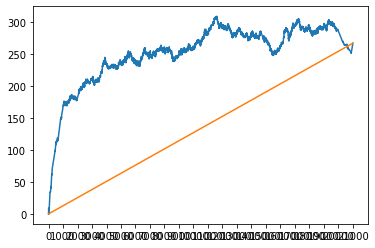

In [20]:
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier
from uplift.ensemble import RandomForestClassifier

from scipy import stats
RANDOM_STATE = 12


max_features = 1.0
min_samples_leaf =  4000
criterion = 'uplift_gini'

clf_tree = RandomForestClassifier(n_estimators = 30, min_samples_leaf = min_samples_leaf, 
        max_features = max_features, max_depth = None, criterion=criterion, random_state=RANDOM_STATE)

print(clf_tree)

clf_tree = clf_tree.fit(x_train, y_train, treatment_train)


from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []



df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

# print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = df_train_feats.loc[indices_valid_new, :]
    
    


    valid_pred = clf_tree.predict_uplift(X_valid)

   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate=0.05)
   
    
    all_res_uplift.append(valid_scores)
   
    
    
from uplift.metrics import qini_auc_score, uplift_at_k, qini_percentile, qini_curve
from uplift.vizualization import plot_qini_curve



x1, y1 = qini_curve(target_valid, valid_pred, treatment_valid)
plt.plot(x1,y1)
plt.xticks(np.arange (0, x1[len(x1)-1], step=1000))
plt.plot([ x1[0], x1[len(x1)-1] ], [ y1[0], y1[len(y1) - 1  ]] )

print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ",stats.sem(all_res_uplift),"| std: ", np.std(all_res_uplift, ddof = 1))


RandomForestClassifier(bootstrap=True, class_weight=None,
            criterion='uplift_gini', max_depth=None, max_features=1.0,
            max_leaf_nodes=None, min_samples_leaf=4000,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=12,
            stat_param=1000.0, verbose=0, warm_start=False)
Mem. usage decreased to  4.20 Mb (69.4% reduction)
Число замеров 100
uplift5%: mean:  0.3005502756606379 | sem:  0.002322086370239436 | std:  0.02322086370239436


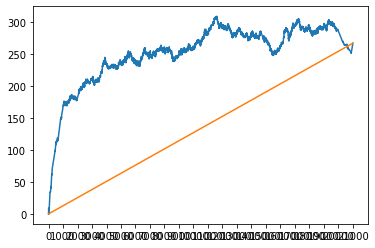

In [7]:
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier
from uplift.ensemble import RandomForestClassifier

from scipy import stats
RANDOM_STATE = 12


max_features = 1.0
min_samples_leaf =  4000
criterion = 'uplift_gini'

clf_tree = RandomForestClassifier(n_estimators = 30, min_samples_leaf = min_samples_leaf, 
        max_features = max_features, max_depth = None, criterion=criterion, random_state=RANDOM_STATE)

print(clf_tree)

clf_tree = clf_tree.fit(x_train, y_train, treatment_train)


from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []



df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

# print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = df_train_feats.loc[indices_valid_new, :]
    
    


    valid_pred = clf_tree.predict_uplift(X_valid)

   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate=0.05)
   
    
    all_res_uplift.append(valid_scores)
   
    
    
from uplift.metrics import qini_auc_score, uplift_at_k, qini_percentile, qini_curve
from uplift.vizualization import plot_qini_curve



x1, y1 = qini_curve(target_valid, valid_pred, treatment_valid)

np.savetxt('x_uplift_tree.txt', x1)
np.savetxt('y_uplift_tree.txt', y1)

plt.plot(x1,y1)
plt.xticks(np.arange (0, x1[len(x1)-1], step=1000))
plt.plot([ x1[0], x1[len(x1)-1] ], [ y1[0], y1[len(y1) - 1  ]] )

print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ",stats.sem(all_res_uplift),"| std: ", np.std(all_res_uplift, ddof = 1))


# Uplift деревья стат тест

In [17]:
criterions = ["stat_test"]
min_samples_leaf =  [int(x) for x in np.linspace(1000, 10000, num = 10)]
max_features = [0.3,0.6,1.0]
param_grid = {
        'criterion':criterions,
        'min_samples_leaf':min_samples_leaf,
        'max_features':max_features


}

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

pprint(param_grid)

{'criterion': ['stat_test'],
 'max_features': [0.3, 0.6, 1.0],
 'min_samples_leaf': [1000,
                      2000,
                      3000,
                      4000,
                      5000,
                      6000,
                      7000,
                      8000,
                      9000,
                      10000]}


In [18]:
from uplift.ensemble import RandomForestClassifier
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

accuracy_auqc = {}
accuracy = {}
num_folds = 2

best_param = {}
best_param_auqc = {}
indices_all_folds = np.array_split(indices_train, num_folds)

print(indices_train.shape)

best_auqc = 0.0

RANDOM_STATE = 12


df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_ =RandomForestClassifier(n_estimators = 30, min_samples_leaf = params['min_samples_leaf'], 
        max_features = params['max_features'], max_depth = None, criterion=params['criterion'], random_state=RANDOM_STATE)



    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_train_feats.loc[indices_all_folds[i]].values
        y_val = treat_y.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_y.loc[indices_all_folds[i],'treatment_flg'].values




        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_train.shape[0] // 2)

        x_train = df_train_feats.loc[united].values
        y_train = treat_y.loc[united, 'target'].values
        treatment_train = treat_y.loc[united, 'treatment_flg'].values
        
                     
                
        clf_.fit(x_train,y_train,treatment_train)
        pred = clf_.predict_uplift(x_val)

        auqc = qini_auc_score(y_val, pred, treatment_val)


        print(params, 'auqc', auqc)
            
            
                
        auqc_res.append(auqc)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[j] = mid
        best_param_auqc[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

(140024,)
Mem. usage decreased to  4.20 Mb (69.4% reduction)
iteration 0  with params {'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 1000}
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 1000} auqc 20176492.878560595
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 1000} auqc 19851099.104427524
iteration 0, auqc 20013795.99149406, params [{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 1000}]
iteration 1  with params {'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 2000}
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 2000} auqc 21735178.563660666
{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 2000} auqc 19555139.378912345
iteration 1, auqc 20645158.971286505, params [{'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 2000}]
iteration 2  with params {'criterion': 'stat_test', 'max_features': 0.3, 'min_samples_leaf': 3000}
{'criteri

{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 6000} auqc 8852319.121023633
iteration 26  with params {'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 7000}
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 7000} auqc 8849377.884865016
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 7000} auqc 9055109.917659052
iteration 27  with params {'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 8000}
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 8000} auqc 7799052.7038176805
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 8000} auqc 9169854.478332914
iteration 28  with params {'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 9000}
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 9000} auqc 7856651.646527074
{'criterion': 'stat_test', 'max_features': 1.0, 'min_samples_leaf': 9000} auqc 8449620.310788125
iteration 29  with p

In [20]:
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier


RANDOM_STATE = 12


max_features = 1.0
min_samples_leaf =  4000
criterion = 'stat_test'

clf_tree = RandomForestClassifier(n_estimators = 30, min_samples_leaf = min_samples_leaf, 
        max_features = max_features, max_depth = None, criterion=criterion, random_state=RANDOM_STATE)

print(clf_tree)

clf_tree = clf_tree.fit(x_train, y_train, treatment_train)


from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []


df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = df_train_feats.loc[indices_valid_new, :]
    
    


    valid_pred = clf_tree.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

RandomForestClassifier(bootstrap=True, class_weight=None,
            criterion='stat_test', max_depth=None, max_features=1.0,
            max_leaf_nodes=None, min_samples_leaf=4000,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=12,
            stat_param=1000.0, verbose=0, warm_start=False)
Mem. usage decreased to  4.20 Mb (69.4% reduction)
            treatment_flg  target
client_id                        
000012768d              0       1
000036f903              1       1
00010925a5              1       1
0001f552b0              1       1
00020e7b18              1       1
000220a0a7              0       1
00022fd34f              1       1
0002ce2217              0       1
00031cbbe6              0       1
00035a21d9              0       0
00038f9200              1       1
0004231e2a              1       0
0004254599              0       0
00042a927a              0       1
0004315e57              0 

Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.5111

RandomForestClassifier(bootstrap=True, class_weight=None,
            criterion='stat_test', max_depth=None, max_features=1.0,
            max_leaf_nodes=None, min_samples_leaf=4000,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=12,
            stat_param=1000.0, verbose=0, warm_start=False)
Mem. usage decreased to  4.20 Mb (69.4% reduction)
Число замеров 100
uplift5%: mean:  0.12003227014042053 | sem:  0.002519875596374306 | std:  0.025198755963743057


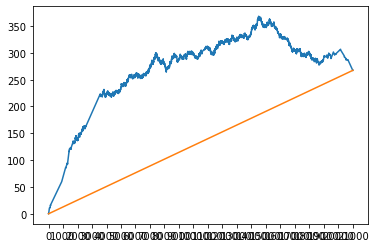

In [21]:
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier


RANDOM_STATE = 12


max_features = 1.0
min_samples_leaf =  4000
criterion = 'stat_test'

clf_tree = RandomForestClassifier(n_estimators = 30, min_samples_leaf = min_samples_leaf, 
        max_features = max_features, max_depth = None, criterion=criterion, random_state=RANDOM_STATE)

print(clf_tree)

clf_tree = clf_tree.fit(x_train, y_train, treatment_train)


from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []


df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

# print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = df_train_feats.loc[indices_valid_new, :]
    
    


    valid_pred = clf_tree.predict_uplift(X_valid)

   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate=0.05)
       
    
    all_res_uplift.append(valid_scores)
   
    
from uplift.metrics import qini_auc_score, uplift_at_k, qini_percentile, qini_curve
from uplift.vizualization import plot_qini_curve



x1, y1 = qini_curve(target_valid, valid_pred, treatment_valid)
plt.plot(x1,y1)
plt.xticks(np.arange (0, x1[len(x1)-1], step=1000))
plt.plot([ x1[0], x1[len(x1)-1] ], [ y1[0], y1[len(y1) - 1  ]] )

print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ",stats.sem(all_res_uplift),"| std: ", np.std(all_res_uplift, ddof = 1))


RandomForestClassifier(bootstrap=True, class_weight=None,
            criterion='stat_test', max_depth=None, max_features=1.0,
            max_leaf_nodes=None, min_samples_leaf=4000,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=12,
            stat_param=1000.0, verbose=0, warm_start=False)
Mem. usage decreased to  4.20 Mb (69.4% reduction)
Число замеров 100
uplift5%: mean:  0.12003227014042053 | sem:  0.002519875596374306 | std:  0.025198755963743057


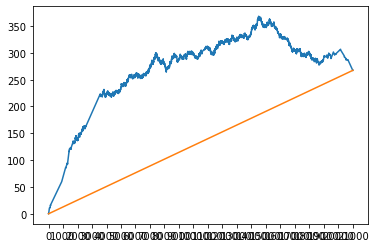

In [8]:
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier


RANDOM_STATE = 12


max_features = 1.0
min_samples_leaf =  4000
criterion = 'stat_test'

clf_tree = RandomForestClassifier(n_estimators = 30, min_samples_leaf = min_samples_leaf, 
        max_features = max_features, max_depth = None, criterion=criterion, random_state=RANDOM_STATE)

print(clf_tree)

clf_tree = clf_tree.fit(x_train, y_train, treatment_train)


from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []


df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

# print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = df_train_feats.loc[indices_valid_new, :]
    
    


    valid_pred = clf_tree.predict_uplift(X_valid)

   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate=0.05)
       
    
    all_res_uplift.append(valid_scores)
   
    
from uplift.metrics import qini_auc_score, uplift_at_k, qini_percentile, qini_curve
from uplift.vizualization import plot_qini_curve



x1, y1 = qini_curve(target_valid, valid_pred, treatment_valid)

np.savetxt('x_uplift_tree_stat_test.txt', x1)
np.savetxt('y_uplift_tree_stat_test.txt', y1)

plt.plot(x1,y1)
plt.xticks(np.arange (0, x1[len(x1)-1], step=1000))
plt.plot([ x1[0], x1[len(x1)-1] ], [ y1[0], y1[len(y1) - 1  ]] )

print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| sem: ",stats.sem(all_res_uplift),"| std: ", np.std(all_res_uplift, ddof = 1))


Ячейки ниже не являеются результатаыми и носят экспериментальный характер

# одна модель

In [55]:
df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)


indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)

x_train = df_train_feats.loc[indices_train].values
x_test = df_train_feats.loc[indices_test].values

eval_set =  [(np.column_stack((x_test,treatment_test)), y_test)] 

Mem. usage decreased to  4.20 Mb (69.4% reduction)


In [15]:
from uplift.models import OneModel

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

xgb_est_params = {
    'max_depth':2,
    'learning_rate': 0.2, 
    'n_estimators':200,
    'nthread':40,
    'n_gpus':0,
    'seed':42
}
df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)

estimator_x = XGBClassifier(
    **xgb_est_params
)
    
estimator = XGBClassifier(max_depth=8,
    learning_rate=0.001,
    n_estimators=4000,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=42,
)

clf_ = LGBMClassifier(
    boosting_type='rf',
    n_estimators=15000,
    num_leaves=40,
    max_depth=3,
    max_bin=110,
    # reg_lambda=1,
    learning_rate=0.001,
    random_state=12,
    n_jobs=-1,
    bagging_freq=1,
    bagging_fraction=0.5,
    importance_type='split',
    is_unbalance=True,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    objective='binary',
    reg_alpha=0.0,
    reg_lambda=0.0,
    silent=True,
    subsample=1.0,
    subsample_for_bin=200000,
    subsample_freq=0,
)



uplift_model_solo = OneModel(
    estimator=estimator)

indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)

x_train = df_train_feats.loc[indices_train].values
x_test = df_train_feats.loc[indices_test].values

eval_set =  [(np.column_stack((x_test,treatment_test)), y_test)] 

Mem. usage decreased to  4.20 Mb (69.4% reduction)


In [17]:
uplift_model_solo.fit(x_train,
                      y_train, 
                      treatment_train
)

OneModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1, gamma=0, gpu_id=-1,
                                 importance_type='gain',
                                 interaction_constraints=None,
                                 learning_rate=0.001, max_delta_step=0,
                                 max_depth=8, min_child_weight=1, missing=nan,
                                 monotone_constraints=None, n_estimators=4000,
                                 n_jobs=-1, nthread=-1, num_parallel_tree=1,
                                 random_state=0, reg_alpha=0, reg_lambda=1,
                                 scale_pos_weight=1, seed=42, silent=None,
                                 subsample=0.7, tree_method=None,
                                 validate_parameters=False, verbosity=None))

In [41]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
copy = df_train_feats.copy()
copy = copy.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = copy.loc[indices_valid_new, :].values
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values
    


    valid_pred = uplift_model_solo.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843

Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Число замеров 100
AUQC: mean:  508943.2464931958 | std:  325356.13223064574
uplift30%: mean:  0.04207077481362665 | std:  0.00955486265163718
Kendall_rank_correlation: mean:  0.12355555555555554 | std:  0.1590694977842306
AUUC: mean:  0.008509246330153432 | std:  0.005346026150687807


In [32]:
from uplift.metrics import Kendall_rank_correlation
from uplift.metrics import uplift_at_k

pred = uplift_model_solo.predict(x_test)
print(Kendall_rank_correlation(y_test, pred, treatment_test))
print(uplift_at_k(y_test, pred, treatment_test))

Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
(0.6444444444444444, 0.009148478835978836)
0.0485112055197352


In [9]:
#xgboost 8913 lin reg

from uplift.metrics import Kendall_rank_correlation
from uplift.metrics import uplift_at_k

pred = uplift_model_solo.predict(x_test)
print(Kendall_rank_correlation(y_test, pred, treatment_test))
print(uplift_at_k(y_test, pred, treatment_test))

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
(0.4222222222222222, 0.10831349206349207)
0.05301880510789958


In [6]:
#light gbm
from uplift.metrics import Kendall_rank_correlation
from uplift.metrics import uplift_at_k

pred = uplift_model_solo.predict(x_test)
print(Kendall_rank_correlation(y_test, pred, treatment_test))
print(uplift_at_k(y_test, pred, treatment_test))

Kendal uplift rank correlation =  0.39770583933420295 with p_value =  0.15443051915129236
(0.39770583933420295, 0.15443051915129236)
0.044200800686234776


In [34]:
print(x_train.loc[indices_test])

KeyError: "None of [Index(['6d49a59587', '9695c3a876', '7f2354b541', '248ca61f9e', '2b1b736806',\n       '1acf146637', 'd83a2ad293', '3ded359162', 'a2af422ba1', '54cb7a04e8',\n       ...\n       'c225710846', '3f3745c3c3', '9cea72d974', '3789a87c49', 'fa36b636bd',\n       'e2feb2e650', 'bd078ee3f8', '3445de498f', 'fc6225eaf8', 'ac547da30a'],\n      dtype='object', name='client_id', length=60012)] are in the [index]"

In [41]:
from uplift.metrics import Kendall_rank_correlation
from uplift.metrics import uplift_at_k
from uplift.metrics import qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = x_test.loc[indices_valid_new, :]
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values


    valid_pred = uplift_model_solo.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)

print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_v

Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Число замеров 100
AUQC: mean:  1306082.974228687 | std:  313348.3398194567
uplift30%: mean:  0.049239999906536804 | std:  0.010145338087811314
Kendall_rank_correlation: mean:  0.5497777777777778 | std:  0.13305695260859526


In [18]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []



df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
copy = df_train_feats.copy()
copy = copy.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = copy.loc[indices_valid_new, :].values
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values


    valid_pred = uplift_model_solo.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =

Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Число замеров 100
AUQC: mean:  1281452.930190214 | std:  316153.809627757
uplift30%: mean:  0.04949205612128726 | std:  0.010483052794791442
Kendall_rank_correlation: mean:  0.5293333333333333 | std:  0.13970485340743968
AUUC: mean:  0.020755375277124413 | std:  0.005174563010317218


## Трансформация классов

In [31]:
from uplift.models import ClassTransformation

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

xgb_est_params = {
    'max_depth':2,
    'learning_rate': 0.2, 
    'n_estimators': 100,
    'nthread':40,
    'n_gpus':0,
    'seed':42
}

estimator = XGBClassifier(
    **xgb_est_params
)

uplift_model_cl_tr = ClassTransformation(
    estimator=estimator
)

indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

x_train = df_train_feats.loc[indices_train].values
x_test = df_train_feats.loc[indices_test].values

In [32]:
uplift_model_cl_tr.fit(
    X=x_train,
    y=y_train,
    treatment=treatment_train
)

ClassTransformation(estimator=XGBClassifier(base_score=0.5, booster=None,
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_delta_step=0,
                                            max_depth=2, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_gpus=0,
                                            n_jobs=40, nthread=40,
                                            num_parallel_tree=1,
                                            random_state=42, reg_alpha=0,
       

In [33]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
copy = df_train_feats.copy()
copy = copy.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = copy.loc[indices_valid_new, :].values
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values
    


    valid_pred = uplift_model_cl_tr.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0

Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Число замеров 100
AUQC: mean:  2013678.7345307013 | std:  334418.60499623977
uplift30%: mean:  0.0734643585795856 | std:  0.008894307358525916
Kendall_rank_correlation: mean:  0.3360000000000001 | std:  0.15891137322958804
AUUC: mean:  0.03111335315028342 | std:  0.00535354240824418


uplift30% 0.07184827540857741
auqc 16629613.202034298


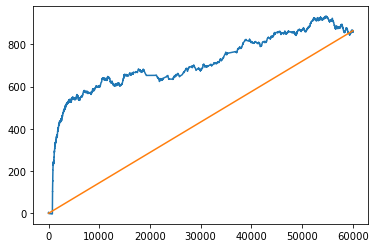

In [76]:
from uplift.metrics import qini_auc_score, uplift_at_k, qini_percentile, qini_curve
from uplift.vizualization import plot_qini_curve

uplift = uplift_model_cl_tr.predict(x_test)

print('uplift30%', uplift_at_k(y_test,uplift, treatment_test))
print('auqc', qini_auc_score(y_test,uplift, treatment_test))

x, y = qini_curve(y_test,uplift, treatment_test)
plt.plot(x,y)
plt.plot([ x[0], x[len(x)-1] ], [ y[0], y[len(y) - 1  ]] )


In [71]:
from uplift.models import ClassTransformation

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

xgb_est_params = {
    'max_depth':2,
    'learning_rate': 0.01, 
    'n_estimators': 300,
    'nthread':40,
    'n_gpus':0,
    'seed':42
}

estimator = XGBClassifier(
    **xgb_est_params
)

uplift_model_cl_tr = ClassTransformation(
    estimator=estimator
)

indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

x_train = df_train_feats.loc[indices_train]
x_test = df_train_feats.loc[indices_test]

In [72]:
uplift_model_cl_tr.fit(
    X=x_train,
    y=y_train,
    treatment=treatment_train
)

d:\work\ml_in_trading\uplift-master(курсовая_гитхаб_нужная_библиотека\uplift\models\models.py:78: UserWarning:

sample size is not balanced.



ClassTransformation(estimator=XGBClassifier(base_score=0.5, booster=None,
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.01,
                                            max_delta_step=0, max_depth=2,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=300, n_gpus=0,
                                            n_jobs=40, nthread=40,
                                            num_parallel_tree=1,
                                            random_state=42, reg_alpha=0,
      

uplift30% 0.06803892889555535
auqc 19125260.756169867


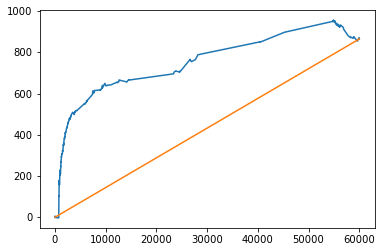

In [73]:
from uplift.metrics import qini_auc_score, uplift_at_k, qini_percentile, qini_curve
from uplift.vizualization import plot_qini_curve

uplift = uplift_model_cl_tr.predict(x_test)

print('uplift30%', uplift_at_k(y_test,uplift, treatment_test))
print('auqc', qini_auc_score(y_test,uplift, treatment_test))

x, y = qini_curve(y_test,uplift, treatment_test)
plt.plot(x,y)
plt.plot([ x[0], x[len(x)-1] ], [ y[0], y[len(y) - 1  ]] )


In [65]:
from uplift.metrics import uplift_at_k, qini_auc_score

auqc = []
uplift30 =[]
for j in range( 1, 300, 10):
  RANDOM_STATE = j
  indices_learn_new, indices_valid_new = train_test_split(
                indices_test,
                test_size=0.9,
                random_state = RANDOM_STATE,
  )
  df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
  treatment_test = df_train_feats.loc[indices_valid_new,'treatment_flg']
  y_test = df_train_feats.loc[indices_valid_new,'target']
  df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
        )
  x_test = df_train_feats.loc[indices_valid_new]


  uplift = uplift_model_cl_tr.predict(x_test)

    
  uplift30.append(uplift_at_k(y_test, uplift, treatment_test))
  

  auqc.append(qini_auc_score(y_test, uplift, treatment_test))

print('uplift30%', np.mean(uplift30), np.std(uplift30))
print('auqc', np.mean(auqc), np.std(auqc))

  

uplift30% 0.07327337222055548 0.007756743948850623
auqc 2076469.5042964246 229835.8805231932


## Одна модель

### Tune

In [125]:
from uplift.models import TwoModels



xgb_try_params = [
  (1, 10, 1),
  (2, 20, 0.5),
  (2, 100, 0.5),
  (2, 200, 0.4),
  (3, 100, 0.5),
    (10, 200, 0.01),
    (10, 300, 0.01),
    (10, 400, 0.01)
]

auqc_mean = []
uplift30_mean = []
for param in xgb_try_params:
    df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
    d, n, eta = param[0], param[1], param[2]
    print(f'Parms: {param}')

    xgb_est_params = {
        'max_depth':d, 
        'learning_rate':eta, 
        'n_estimators':n,
        'n_gpus':0,
        'seed':0
    }

    estimator = XGBClassifier(
        **xgb_est_params
    )

    uplift_model_solo = OneModel(
        estimator = estimator )

    indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
    )


    treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
    y_train = df_train_feats.loc[indices_train,'target']


    treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
    y_test = df_train_feats.loc[indices_test,'target']

    df_train_feats = df_train_feats.drop(
                ['treatment_flg', 'target'], 
                axis=1
    )

    x_train = df_train_feats.loc[indices_train]
    x_test = df_train_feats.loc[indices_test]
    
    uplift_model_solo.fit(
        X=x_train,
        y=y_train,
        treatment=treatment_train
    )
    
    from uplift.metrics import uplift_at_k, qini_auc_score

    auqc = []
    uplift30 =[]
    
    for j in range( 1, 300, 10):
        RANDOM_STATE = j
        indices_learn_new, indices_valid_new = train_test_split(
                    indices_test,
                    test_size=0.9,
                    random_state = RANDOM_STATE,
        )
        df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
        treatment_test = df_train_feats.loc[indices_valid_new,'treatment_flg']
        y_test = df_train_feats.loc[indices_valid_new,'target']
        df_train_feats = df_train_feats.drop(
                ['treatment_flg', 'target'], 
                axis=1
            )
        x_test = df_train_feats.loc[indices_valid_new]


        uplift = uplift_model_solo.predict(x_test)
        uplift30.append(uplift_at_k(y_test, uplift, treatment_test))
        auqc.append(qini_auc_score(y_test, uplift, treatment_test))

    print('uplift30%', np.mean(uplift30), np.std(uplift30))
    print('auqc', np.mean(auqc), np.std(auqc))
    auqc_mean.append( np.mean(auqc))
    uplift30_mean.append(np.mean(uplift30))


Parms: (1, 10, 1)
uplift30% 0.028553472782266866 0.006503244257977307
auqc 0.0 0.0
Parms: (2, 20, 0.5)
uplift30% 0.04462997095353776 0.0030238112648410236
auqc 2325152.0922354236 655895.1999567227
Parms: (2, 100, 0.5)
uplift30% 0.048571210744695864 0.0025248326538126523
auqc 3788834.652172443 661818.156401079
Parms: (2, 200, 0.4)
uplift30% 0.0438064081308852 0.002479260949761754
auqc 3124645.479487251 637627.5807905138
Parms: (3, 100, 0.5)
uplift30% 0.03723642245085816 0.0025081205668997875
auqc 1165353.9701388439 605013.181708368
Parms: (10, 200, 0.01)
uplift30% 0.04937189795270682 0.002571455141893922
auqc 5591187.718143866 635286.6508129891
Parms: (10, 300, 0.01)
uplift30% 0.03956728831071573 0.0024498343827045583
auqc 5004465.630699492 653382.5014909509
Parms: (10, 400, 0.01)
uplift30% 0.040245414947678436 0.002442754771639311
auqc 3819507.1039808197 635790.2763373828


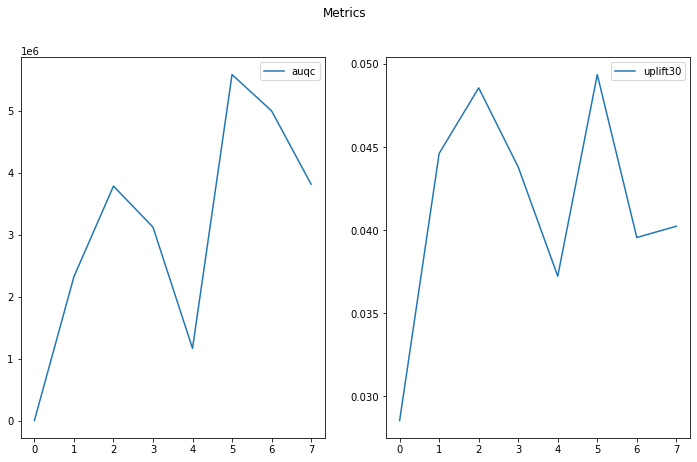

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,7))
fig.suptitle('Metrics')
ax1.plot(auqc_mean, label='auqc')
ax1.legend()
ax2.plot(uplift30_mean, label = 'uplift30')
ax2.legend()

### Построение модели

In [55]:
from uplift.models import OneModel

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

xgb_est_params = {
    'max_depth':2,
    'learning_rate': 0.05, 
    'n_estimators': 300,
    'nthread':40,
    'n_gpus':0,
    'seed':42
}

estimator = XGBClassifier(
    **xgb_est_params
)

uplift_model_solo = OneModel(
    estimator=estimator
)

indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

x_train = df_train_feats.loc[indices_train]
x_test = df_train_feats.loc[indices_test]

In [56]:
uplift_model_solo.fit(
    X=x_train,
    y=y_train,
    treatment=treatment_train
)

OneModel(estimator=XGBClassifier(base_score=0.5, booster=None,
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1, gamma=0, gpu_id=-1,
                                 importance_type='gain',
                                 interaction_constraints=None,
                                 learning_rate=0.05, max_delta_step=0,
                                 max_depth=2, min_child_weight=1, missing=nan,
                                 monotone_constraints=None, n_estimators=300,
                                 n_gpus=0, n_jobs=40, nthread=40,
                                 num_parallel_tree=1, random_state=42,
                                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                 seed=42, subsample=1, tree_method=None,
                                 validate_parameters=False, verbosity=None))

uplift30% 0.04909671769590035
auqc 6007585.3473812975


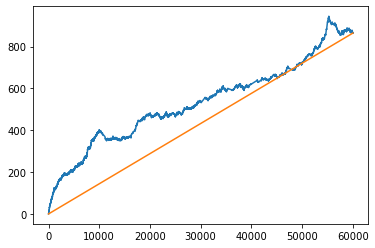

In [58]:
from uplift.metrics import qini_auc_score, uplift_at_k, qini_percentile, qini_curve
from uplift.vizualization import plot_qini_curve

uplift = uplift_model_solo.predict(x_test)

print('uplift30%', uplift_at_k(y_test,uplift, treatment_test))
print('auqc', qini_auc_score(y_test,uplift, treatment_test))

x, y = qini_curve(y_test,uplift, treatment_test)
plt.plot(x,y)
plt.plot([ x[0], x[len(x)-1] ], [ y[0], y[len(y) - 1] ] )


In [59]:
from uplift.metrics import uplift_at_k, qini_auc_score

auqc = []
uplift30 =[]
for j in range( 1, 300, 10):
  RANDOM_STATE = j
  indices_learn_new, indices_valid_new = train_test_split(
                indices_test,
                test_size=0.9,
                random_state = RANDOM_STATE,
  )
  df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
  treatment_test = df_train_feats.loc[indices_valid_new,'treatment_flg']
  y_test = df_train_feats.loc[indices_valid_new,'target']
  df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
        )
  x_test = df_train_feats.loc[indices_valid_new]


  uplift = uplift_model_solo.predict(x_test)

    
  uplift30.append(uplift_at_k(y_test, uplift, treatment_test))
  

  auqc.append(qini_auc_score(y_test, uplift, treatment_test))

print('uplift30%', np.mean(uplift30), np.std(uplift30))
print('auqc', np.mean(auqc), np.std(auqc))

  

uplift30% 0.04943903444438667 0.0027229220030634965
auqc 4990043.089430829 677332.8289206277


## Две модели

### Tune


In [97]:
from uplift.models import TwoModels



xgb_try_params = [
  (1, 10, 1),
  (2, 20, 0.5),
  (2, 100, 0.5),
  (2, 200, 0.4),
  (3, 100, 0.5)  
]

auqc_mean = []
uplift30_mean = []
for param in xgb_try_params:
    df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
    d, n, eta = param[0], param[1], param[2]
    print(f'Parms: {param}')

    xgb_est_params = {
        'max_depth':d, 
        'learning_rate':eta, 
        'n_estimators':n,
        'n_gpus':0,
        'seed':0
    }




    base_params = {'learning_rate': 0.05,
     'max_depth': 15,
     'objective': 'binary',
     'subsample': 0.35,
     'colsample_bytree': 0.75,
     'reg_alpha': 0.0,
     'bagging_freq': 3,
     'reg_lambda': 0.0,
     'seed': 42,
     'verbose': 1,
    'n_estimators':300
    }

    estimator1  = LGBMClassifier(
        **base_params
    )

    estimator2 = XGBClassifier(
        **xgb_est_params
    )

    uplift_model_two_indep = TwoModels(
        estimator_trmnt = estimator1, estimator_ctrl = estimator2, method='two_independent'
    )

    indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
    )


    treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
    y_train = df_train_feats.loc[indices_train,'target']


    treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
    y_test = df_train_feats.loc[indices_test,'target']

    df_train_feats = df_train_feats.drop(
                ['treatment_flg', 'target'], 
                axis=1
    )

    x_train = df_train_feats.loc[indices_train]
    x_test = df_train_feats.loc[indices_test]
    
    uplift_model_two_indep.fit(
        X=x_train,
        y=y_train,
        treatment=treatment_train
    )
    
    from uplift.metrics import uplift_at_k, qini_auc_score

    auqc = []
    uplift30 =[]
    for j in range( 1, 300, 10):
      RANDOM_STATE = j
      indices_learn_new, indices_valid_new = train_test_split(
                    indices_test,
                    test_size=0.9,
                    random_state = RANDOM_STATE,
      )
      df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
      treatment_test = df_train_feats.loc[indices_valid_new,'treatment_flg']
      y_test = df_train_feats.loc[indices_valid_new,'target']
      df_train_feats = df_train_feats.drop(
                ['treatment_flg', 'target'], 
                axis=1
            )
      x_test = df_train_feats.loc[indices_valid_new]


      uplift = uplift_model_two_indep.predict(x_test)


      uplift30.append(uplift_at_k(y_test, uplift, treatment_test))


      auqc.append(qini_auc_score(y_test, uplift, treatment_test))

    print('uplift30%', np.mean(uplift30), np.std(uplift30))
    print('auqc', np.mean(auqc), np.std(auqc))
    auqc_mean.append( np.mean(auqc))
    uplift30_mean.append(np.mean(uplift30))


Parms: (1, 10, 1)
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 44580, number of negative: 25469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 70049, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.636412 -> initscore=0.559823
[LightGBM] [Info] Start training from score 0.559823
uplift30% 0.06575079830905023 0.0016523577342810922
auqc 8601055.243

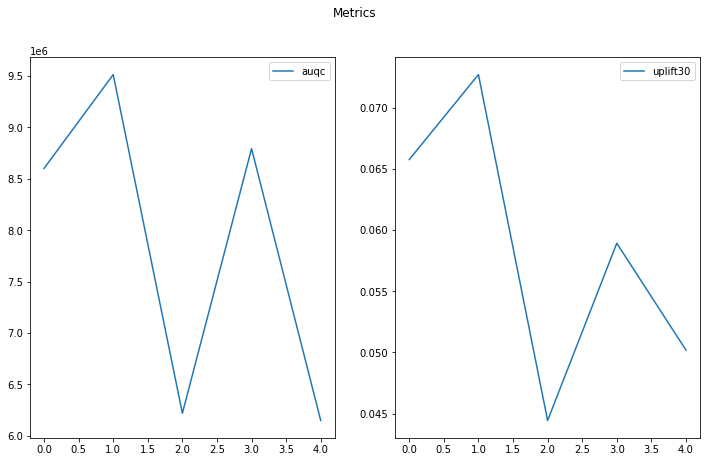

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,7))
fig.suptitle('Metrics')
ax1.plot(auqc_mean, label='auqc')
ax1.legend()
ax2.plot(uplift30_mean, label = 'uplift30')
ax2.legend()

In [123]:
print("params best (2, 20, 0.5)")

params best (2, 20, 0.5)


best_result 

uplift30% 0.07268795754108853 0.0020889682375232655

auqc 9514465.774090173 449650.26151446224

In [133]:
from uplift.models import TwoModels

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

xgb_est_params = {
    'max_depth':2,
    'learning_rate': 0.5, 
    'n_estimators': 20,
    'n_gpus':0,
    'seed':0
}

base_params = {'learning_rate': 0.05,
     'max_depth': 15,
     'objective': 'binary',
     'subsample': 0.35,
     'colsample_bytree': 0.75,
     'reg_alpha': 0.0,
     'bagging_freq': 3,
     'reg_lambda': 0.0,
     'seed': 42,
     'verbose': 1,
    'n_estimators':300
    }

estimator1  = LGBMClassifier(
    **base_params
)

estimator2 = XGBClassifier(
    **xgb_est_params
)

uplift_model_two_indep = TwoModels(
    estimator_trmnt = estimator1, estimator_ctrl = estimator2, method='two_independent'
)

indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

x_train = df_train_feats.loc[indices_train]
x_test = df_train_feats.loc[indices_test]

In [134]:
uplift_model_two_indep.fit(
    X=x_train,
    y=y_train,
    treatment=treatment_train
)

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 44580, number of negative: 25469
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 70049, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.636412 -> initscore=0.559823
[LightGBM] [Info] Start training from score 0.559823


TwoModels(estimator_ctrl=XGBClassifier(base_score=0.5, booster=None,
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0, gpu_id=-1,
                                       importance_type='gain',
                                       interaction_constraints=None,
                                       learning_rate=0.5, max_delta_step=0,
                                       max_depth=2, min_child_weight=1,
                                       missing=nan, monotone_constraints=None,
                                       n_estimators=20, n_gpus=0, n_jobs=0,
                                       num_parallel_tree=1, random_state=0,
                                       reg_alpha=0, reg_lambda=1,
                                       scale_pos_weight=1, seed=0, subsample=1,
                                       tree_method=None,
                                       validate_parameters

uplift30% 0.07275053582472579
auqc 11537026.35750259


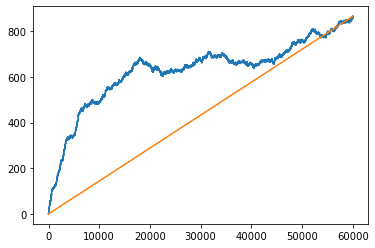

In [135]:
from uplift.metrics import qini_auc_score, uplift_at_k, qini_percentile, qini_curve
from uplift.vizualization import plot_qini_curve

uplift = uplift_model_two_indep.predict(x_test)

print('uplift30%', uplift_at_k(y_test,uplift, treatment_test))
print('auqc', qini_auc_score(y_test,uplift, treatment_test))

x, y = qini_curve(y_test,uplift, treatment_test)
plt.plot(x,y)
plt.plot([ x[0], x[len(x)-1] ], [ y[0], y[len(y) - 1] ] )


In [136]:
from uplift.metrics import uplift_at_k, qini_auc_score

auqc = []
uplift30 =[]
for j in range( 1, 300, 10):
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
                indices_test,
                test_size=0.9,
                random_state = RANDOM_STATE,
    )
    df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
    treatment_test = df_train_feats.loc[indices_valid_new,'treatment_flg']
    y_test = df_train_feats.loc[indices_valid_new,'target']
    df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
        )
    x_test = df_train_feats.loc[indices_valid_new]


    uplift = uplift_model_two_indep.predict(x_test)


    uplift30.append(uplift_at_k(y_test, uplift, treatment_test))


    auqc.append(qini_auc_score(y_test, uplift, treatment_test))

print('uplift30%', np.mean(uplift30), np.std(uplift30))
print('auqc', np.mean(auqc), np.std(auqc))

uplift30% 0.07268795754108853 0.0020889682375232655
auqc 9514465.774090173 449650.26151446224


# Uplift деревья стат тест

In [ ]:
df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)


indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)

x_train = df_train_feats.loc[indices_train].values
x_test = df_train_feats.loc[indices_test].values

eval_set =  [(np.column_stack((x_test,treatment_test)), y_test)] 

In [53]:
from sklearn.model_selection import ParameterGrid
from pprint import pprint
from uplift.ensemble import RandomForestClassifier

criterions = ["stat_test"]
min_samples_leaf = [5000]
stat_param=[40.0]
param_grid = {
        'criterion':criterions,
        'min_samples_leaf':min_samples_leaf,
        'stat_param':stat_param

}

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

pprint(param_grid)
results =[]
config = []
best_res = 0


for params in grid_list:
        
    print(params)

    uplift_tree_stat =RandomForestClassifier(n_estimators = 15, min_samples_leaf = params['min_samples_leaf'], 
        max_features = 1.0, max_depth = None, criterion=params['criterion'], stat_param=params['stat_param'])

    
    
    uplift_tree_stat.fit(x_train, y_train, treatment_train)

{'criterion': ['stat_test'], 'min_samples_leaf': [5000], 'stat_param': [40.0]}
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 40.0}


In [57]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
copy = df_train_feats.copy()
copy = copy.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = copy.loc[indices_valid_new, :].values
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values
    


    valid_pred = uplift_tree_stat.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Mem. usage decreased to  4.20 Mb (69.4% reduction)
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6 with p_value =  0.0166661155202

Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Число замеров 100
AUQC: mean:  2031708.9456004263 | std:  360360.5528516194
uplift30%: mean:  0.07485794087735731 | std:  0.01027653317107994
Kendall_rank_correlation: mean:  0.5977777777777777 | std:  0.1298266900431573
AUUC: mean:  0.03234030177916562 | std:  0.005793101433547442


# uplift деревья

In [58]:
from sklearn.model_selection import ParameterGrid
from pprint import pprint
from uplift.ensemble import RandomForestClassifier

criterions = ["uplift_gini"]
min_samples_leaf = [5000]
param_grid = {
        'criterion':criterions,
        'min_samples_leaf':min_samples_leaf

}

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

pprint(param_grid)
results =[]
config = []
best_res = 0


for params in grid_list:
        
    print(params)

    uplift_tree =RandomForestClassifier(n_estimators = 15, min_samples_leaf = params['min_samples_leaf'], 
        max_features = 1.0, max_depth = None, criterion=params['criterion'])

    
    
    uplift_tree.fit(x_train, y_train, treatment_train)

{'criterion': ['uplift_gini'], 'min_samples_leaf': [5000]}
{'criterion': 'uplift_gini', 'min_samples_leaf': 5000}


In [62]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

df_train_feats = reduce_mem_usage(df_train_feats)


df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)

copy = df_train_feats.copy()
copy = copy.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = copy.loc[indices_valid_new, :].values
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values
    


    valid_pred = uplift_tree.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Mem. usage decreased to  4.20 Mb (69.4% reduction)
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Число замеров 100
AUQC: mean:  2071561.2481514744 | std:  393785.14412585425
uplift30%: mean:  0.07426348449867295 | std:  0.010526020824585213
Kendall_rank_correlation: mean:  0.5586666666666666 | std:  0.14114844367726048
AUUC: mean:  0.03287278309372293 | std:  0.006317996182621756


# Две независимые модели

In [69]:
from uplift.models import TwoModels

RANDOM_STATE = 12


clf_lgbm = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=20,
    max_depth=2,
    learning_rate=0.5,
    random_state=RANDOM_STATE,
    
)

xgb_clf = XGBClassifier(max_depth =2,
            learning_rate= 0.2,
            n_estimators = 100,
            nthread =40,
            n_gpus =0,
            seed = 42)

model_two = TwoModels(estimator_trmnt = clf_lgbm, estimator_ctrl = xgb_clf, method = 'two_independent')

clf = model_two.fit(x_train, y_train, treatment_train)



In [70]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
copy = df_train_feats.copy()
copy = copy.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = copy.loc[indices_valid_new, :].values
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values
    


    valid_pred = model_two.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.28888888888888886 with p_v

Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Число замеров 100
AUQC: mean:  1753810.6959543368 | std:  359176.9958985179
uplift30%: mean:  0.07288056734708484 | std:  0.01007453556512462
Kendall_rank_correlation: mean:  0.44577777777777783 | std:  0.14914880908936098
AUUC: mean:  0.027775564722597238 | std:  0.005747588520361466


# Две зависимые модели T,C

In [84]:
from uplift.models import TwoModels


RANDOM_STATE = 12

clf_lgbm = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.5,
    random_state=RANDOM_STATE,
    
)

xgb_clf = XGBClassifier(max_depth =3,
            learning_rate= 0.5,
            n_estimators = 100,
            nthread =40,
            n_gpus =0,
            seed = 42)

model_two_T = TwoModels(estimator_trmnt = clf_lgbm, estimator_ctrl = xgb_clf, method = 'two_dependent_treatment')
clf = model_two_T.fit(x_train, y_train, treatment_train)




In [85]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
copy = df_train_feats.copy()
copy = copy.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = copy.loc[indices_valid_new, :].values
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values
    


    valid_pred = model_two_T.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank c

Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Число замеров 100
AUQC: mean:  727389.8812680799 | std:  353939.69700642384
uplift30%: mean:  0.046289601162937496 | std:  0.010535992863898575
Kendall_rank_correlation: mean:  0.3186666666666666 | std:  0.1640070623428043
AUUC: mean:  0.012186344486656451 | std:  0.005860953109400921


# Две зависимые модели С,T

In [90]:
from uplift.models import TwoModels

RANDOM_STATE = 12



clf_lgbm = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.4,
    random_state=RANDOM_STATE,
    
)

xgb_clf = XGBClassifier(max_depth =4,
            learning_rate= 0.4,
            n_estimators = 1000,
            nthread =40,
            n_gpus =0,
            seed = 42)

model_two_C = TwoModels(estimator_trmnt = clf_lgbm, estimator_ctrl = xgb_clf, method = 'two_dependent_control')

clf = model_two_C.fit(x_train, y_train, treatment_train)

In [91]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
copy = df_train_feats.copy()
copy = copy.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = copy.loc[indices_valid_new, :].values
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values
    


    valid_pred = model_two_C.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank co

Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Число замеров 100
AUQC: mean:  747220.3121653103 | std:  333631.51602783444
uplift30%: mean:  0.04009570033957057 | std:  0.009161655970037617
Kendall_rank_correlation: mean:  0.3151111111111111 | std:  0.1509624937625497
AUUC: mean:  0.012311726652236702 | std:  0.005482523921486564


# Регрессия трансформация классов

In [4]:


df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

# df_train_feats = reduce_mem_usage(df_train_feats)


# df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)


indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)

p=0.5

df_train_feats['Z_trans'] = df_train_feats['target']* ( (df_train_feats['treatment_flg'] - p) / ( p*(1-p) ) )

all = df_train_feats.copy()
train =all.loc[indices_train,]
test = all.loc[indices_test,]



Z_trans_train = train['Z_trans']
Z_trans_train = Z_trans_train.to_numpy()

Z_trans_test = test['Z_trans']
Z_trans_test = Z_trans_test.to_numpy()

treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target','Z_trans'], 
            axis=1
)

# df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)

x_train = df_train_feats.loc[indices_train].values
x_test = df_train_feats.loc[indices_test].values

eval_set =  [(x_test, Z_trans_test)] 

In [5]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 9, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 9],
 'subsample': [0.4, 0.7, 1.0]}


In [7]:
from uplift.metrics import qini_auc_score, uplift_at_k

accuracy_auqc = {}
accuracy = {}
num_folds = 2

best_param = {}
best_param_auqc = {}


best_auqc = 0.0
lr = 0.01
RANDOM_STATE = 12

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')

p=0.5 

df_train_feats['Z_trans'] = df_train_feats['target']* ( (df_train_feats['treatment_flg'] - p) / ( p*(1-p) ) )
indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)
print(indices_train.shape)
indices_all_folds = np.array_split(indices_train, num_folds)
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target'],
    'transf':df_train_feats['Z_trans']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target','Z_trans'], 
            axis=1
)

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_reg = LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=10000,
        num_leaves=2**params['max_depth'] -1,
        max_depth=params['max_depth'],
        learning_rate=lr,
        colsample_bytree=params['colsample_bytree'],
        subsample= params['subsample'],
        objective='regression',
        metric = 'mse',
        random_state=RANDOM_STATE
    )



    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_train_feats.loc[indices_all_folds[i]].values
        y_val = treat_y.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_y.loc[indices_all_folds[i],'treatment_flg'].values
        z_val = treat_y.loc[indices_all_folds[i],'transf'].values



        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_train.shape[0] // 2)

        x_train = df_train_feats.loc[united].values
        y_train = treat_y.loc[united, 'target'].values
        treatment_train = treat_y.loc[united, 'treatment_flg'].values
        z_train = treat_y.loc[united,'transf'].values
        
        best = 0
        rounds = 0
        step = 30
        print("start early stopping")
        for n_est in range(2,3000,step):
            
            seting = {'n_estimators':n_est}
            print("[",n_est,"]")
            clf_reg.set_params(**seting)
           
            
            
            if (rounds == 3):
                print("earlystopping finish, best iteration", n_est - (step * rounds))
                break
                
            clf_reg = clf_reg.fit(x_train,z_train)
            pred = clf_reg.predict(x_val)

            auqc = qini_auc_score(y_val, pred, treatment_val)
            

            print(params, 'auqc',auqc)
            
            if (auqc > best):
                best = auqc
                rounds = 0
            else:
                rounds += 1
                
        auqc_res.append(best)   
                
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[j] = mid
        best_param_auqc[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 4342059.835844398
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 23468285.841478437
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 23318483.88348165
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 22543478.5424342
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 20866761.378474556
[ 152 ]
earlystopping finish, best iteration 62
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 5169248.334500268
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 23354026.945885308
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 23332437.52590283
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 23585366.338419616
[ 1

{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 19846656.072516836
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 19730723.13630282
[ 152 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 20102824.14815762
[ 182 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 19825955.633785225
[ 212 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 19807060.546264283
[ 242 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.4} auqc 19473576.24554836
[ 272 ]
earlystopping finish, best iteration 182
iteration 4  with params {'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 6300673.1157309115
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 16560876.785437204
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 4, 'subsample': 0.7} auqc 17974956.945531294
[ 92 ]
{'colsample_bytree': 0.4,

{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 1.0} auqc 17357014.016217403
[ 302 ]
earlystopping finish, best iteration 212
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 1.0} auqc 3953758.3851427436
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 1.0} auqc 16804685.47952778
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 1.0} auqc 16391001.99281422
[ 92 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 1.0} auqc 16410698.841366291
[ 122 ]
{'colsample_bytree': 0.4, 'max_depth': 6, 'subsample': 1.0} auqc 16596950.891396418
[ 152 ]
earlystopping finish, best iteration 62
iteration 9  with params {'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4}
start early stopping
[ 2 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 6835499.009356096
[ 32 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample': 0.4} auqc 18015252.290884726
[ 62 ]
{'colsample_bytree': 0.4, 'max_depth': 9, 'subsample

{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.7} auqc 23455399.535850555
[ 302 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.7} auqc 24473962.77737584
[ 332 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.7} auqc 23781756.29073336
[ 362 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.7} auqc 23233488.577147722
[ 392 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 0.7} auqc 22800984.0803885
[ 422 ]
earlystopping finish, best iteration 332
iteration 14  with params {'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 20253227.20852176
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 23464463.77391438
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 23444245.853339612
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 2, 'subsample': 1.0} auqc 23445808.060627475
[ 122 ]
{'colsample_bytree': 0.7, '

start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 13486373.82976827
[ 32 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 13435483.955343924
[ 62 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 14432097.47272434
[ 92 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 14530689.947451316
[ 122 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 14551813.375941895
[ 152 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 14365753.293520994
[ 182 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 14253747.793803051
[ 212 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.7} auqc 13851187.52298063
[ 242 ]
earlystopping finish, best iteration 152
iteration 20  with params {'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0} auqc 20067508.020905033
[ 32 

{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 23829873.173549004
[ 272 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 0.7} auqc 23725032.668957226
[ 302 ]
earlystopping finish, best iteration 212
iteration 26  with params {'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 6555994.715120465
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 6430437.122601502
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 6423013.865358487
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 6423013.865358487
[ 122 ]
earlystopping finish, best iteration 32
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 4425577.398370609
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample': 1.0} auqc 6303410.773877606
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 2, 'subsample':

{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 15790492.50688155
[ 332 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 16277839.635815531
[ 362 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 16179792.194628775
[ 392 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 16084745.69801867
[ 422 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 16064574.621100008
[ 452 ]
earlystopping finish, best iteration 362
iteration 32  with params {'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0}
start early stopping
[ 2 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 19646177.134953342
[ 32 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 19295240.561796427
[ 62 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 16227886.53314957
[ 92 ]
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 16735072.553359598
[ 122 ]
earlystopping finish, be

In [8]:
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier, LGBMRegressor


df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
p=0.5 
df_train_feats['Z_trans'] = df_train_feats['target']* ( (df_train_feats['treatment_flg'] - p) / ( p*(1-p) ) )

indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']
z_train = df_train_feats.loc[indices_train,'Z_trans']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']
z_test = df_train_feats.loc[indices_test,'Z_trans']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target','Z_trans'], 
            axis=1
)



x_train = df_train_feats.loc[indices_train].values
x_test = df_train_feats.loc[indices_test].values





lr=0.01
RANDOM_STATE = 12
max_depth = 2
colsample_bytree = 0.4
subsample=0.4
n_estimators = 422

clf_reg = LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=n_estimators,
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=0.01,
        colsample_bytree=colsample_bytree,
        subsample= subsample,
        objective='regression',
        metric = 'mse',
        random_state = RANDOM_STATE
    )

print(clf_reg)
clf_reg = clf_reg.fit(x_train, z_train)


from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = df_train_feats.loc[indices_valid_new, :]
    
    


    valid_pred = clf_reg.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))


LGBMRegressor(colsample_bytree=0.4, learning_rate=0.01, max_depth=2,
              metric='mse', n_estimators=422, num_leaves=3,
              objective='regression', random_state=12, subsample=0.4)
            treatment_flg  target
client_id                        
000012768d              0       1
000036f903              1       1
00010925a5              1       1
0001f552b0              1       1
00020e7b18              1       1
000220a0a7              0       1
00022fd34f              1       1
0002ce2217              0       1
00031cbbe6              0       1
00035a21d9              0       0
00038f9200              1       1
0004231e2a              1       0
0004254599              0       0
00042a927a              0       1
0004315e57              0       1
00047b3720              1       0
0004e1e14e              0       0
00065f11c7              0       1
00068fd5dc              0       0
0006b9ad75              1       1
0006f24465              0       1
0006fca4bf         

Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlati

In [27]:
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier, LGBMRegressor
from scipy import stats

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
p=0.5 
df_train_feats['Z_trans'] = df_train_feats['target']* ( (df_train_feats['treatment_flg'] - p) / ( p*(1-p) ) )

indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']
z_train = df_train_feats.loc[indices_train,'Z_trans']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']
z_test = df_train_feats.loc[indices_test,'Z_trans']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target','Z_trans'], 
            axis=1
)



x_train = df_train_feats.loc[indices_train].values
x_test = df_train_feats.loc[indices_test].values





lr=0.01
RANDOM_STATE = 12
max_depth = 2
colsample_bytree = 0.4
subsample=0.4
n_estimators = 422

clf_reg = LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=n_estimators,
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=0.01,
        colsample_bytree=colsample_bytree,
        subsample= subsample,
        objective='regression',
        metric = 'mse',
        random_state = RANDOM_STATE
    )

print(clf_reg)
clf_reg = clf_reg.fit(x_train, z_train)



all_res_uplift = []


df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = df_train_feats.loc[indices_valid_new, :]
    
    


    valid_pred = clf_reg.predict(X_valid)
    
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    
    
print('Число замеров', j)
print('uplift5%: mean: ', np.mean(all_res_uplift),"| std: ",stats.sem(all_res_uplift))



LGBMRegressor(colsample_bytree=0.4, learning_rate=0.01, max_depth=2,
              metric='mse', n_estimators=422, num_leaves=3,
              objective='regression', random_state=12, subsample=0.4)
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.377

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Число замеров 100
uplift5%: mean:  0.31318361482438156 | std:  0.002537207163205307


# out.csv

In [93]:
df_train_feats = pd.read_csv("out.csv", index_col = 'client_id')

# df_train_feats = reduce_mem_usage(df_train_feats)


# df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)


indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)

p=0.5

df_train_feats['Z_trans'] = df_train_feats['target']* ( (df_train_feats['treatment_flg'] - p) / ( p*(1-p) ) )

all = df_train_feats.copy()
train =all.loc[indices_train,]
test = all.loc[indices_test,]



Z_trans_train = train['Z_trans']
Z_trans_train = Z_trans_train.to_numpy()

Z_trans_test = test['Z_trans']
Z_trans_test = Z_trans_test.to_numpy()

treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target','Z_trans'], 
            axis=1
)

# df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)

x_train = df_train_feats.loc[indices_train].values
x_test = df_train_feats.loc[indices_test].values

eval_set =  [(x_test, Z_trans_test)] 

Mem. usage decreased to  4.20 Mb (69.4% reduction)


In [22]:
from pprint import pprint

max_depth = [int(x) for x in np.linspace(2, 9, num = 4)]

n_estimators = [int(x) for x in np.linspace(10, 15000, num = 8)]
subsample = [float(x) for x in np.linspace(0.4,1,num=3)]
colsample_bytree = [float(x) for x in np.linspace(0.4,1,num=3)]

param_grid = {
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

{'colsample_bytree': [0.4, 0.7, 1.0],
 'max_depth': [2, 4, 6, 9],
 'subsample': [0.4, 0.7, 1.0]}


In [30]:
accuracy_auqc = {}
accuracy = {}
num_folds = 2

best_param = {}
best_param_auqc = {}


best_auqc = 0.0
lr = 0.01
RANDOM_STATE = 12

df_train_feats = pd.read_csv("out.csv", index_col = 'client_id')

p=0.5 

df_train_feats['Z_trans'] = df_train_feats['target']* ( (df_train_feats['treatment_flg'] - p) / ( p*(1-p) ) )
indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)
print(indices_train.shape)
indices_all_folds = np.array_split(indices_train, num_folds)
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target'],
    'transf':df_train_feats['Z_trans']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target','Z_trans'], 
            axis=1
)

for j, params in enumerate(grid_list):
    print("iteration", j," with params", params)
    
    clf_reg = LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=10000,
        num_leaves=2**params['max_depth'] -1,
        max_depth=params['max_depth'],
        learning_rate=lr,
        colsample_bytree=params['colsample_bytree'],
        subsample= params['subsample'],
        objective='regression',
        metric = 'mse',
        random_state=RANDOM_STATE
    )



    
    auqc_res= []
    
    for i in range(num_folds):

        x_val = df_train_feats.loc[indices_all_folds[i]].values
        y_val = treat_y.loc[indices_all_folds[i],'target'].values
        treatment_val = treat_y.loc[indices_all_folds[i],'treatment_flg'].values
        z_val = treat_y.loc[indices_all_folds[i],'transf'].values



        united = np.vstack(indices_all_folds[0:i]+indices_all_folds[i+1:])
        united = united.reshape(indices_train.shape[0] // 2)

        x_train = df_train_feats.loc[united].values
        y_train = treat_y.loc[united, 'target'].values
        treatment_train = treat_y.loc[united, 'treatment_flg'].values
        z_train = treat_y.loc[united,'transf'].values
        
        
                
        clf_reg = clf_reg.fit(x_train,z_train, eval_set=[(x_val,z_val)],
        eval_metric='mse',
        early_stopping_rounds=100,verbose = 1000)
        
        pred = clf_reg.predict(x_val)

        auqc = qini_auc_score(y_val, pred, treatment_val)
        print(params, 'auqc',auqc)
            
            
                
        auqc_res.append(auqc)   
        
    mid = np.mean(auqc_res)
    if mid > best_auqc:
        accuracy_auqc[j] = mid
        best_param_auqc[j] = [params]
        print("iteration {}, auqc {}, params {}".format(j,mid,[params]))
        best_auqc = mid
        
    
    
print("best accuracies in folds:")
print(accuracy_auqc)
print(best_param_auqc)

(140024,)
iteration 0  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l2: 2.45316
Early stopping, best iteration is:
[1158]	valid_0's l2: 2.45299
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 21371911.16390898
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l2: 2.44008
Early stopping, best iteration is:
[1054]	valid_0's l2: 2.44007
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4} auqc 23010906.042243302
iteration 0, auqc 22191408.60307614, params [{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.4}]
iteration 1  with params {'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.7}
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l2: 2.45316
Early stopping, best iteration is:
[1158]	valid_0's l2: 2.45299
{'colsample_bytree': 0.4, 'max_depth': 2, 'subsample': 0.7} auqc 21371911.16390898

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[338]	valid_0's l2: 2.44033
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.4} auqc 16875897.139344037
iteration 16  with params {'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.7}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[270]	valid_0's l2: 2.4521
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.7} auqc 18948744.719607666
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[338]	valid_0's l2: 2.44033
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 0.7} auqc 16875897.139344037
iteration 17  with params {'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[270]	valid_0's l2: 2.4521
{'colsample_bytree': 0.7, 'max_depth': 4, 'subsample': 1.0} auqc 18948744.7196

Early stopping, best iteration is:
[194]	valid_0's l2: 2.44231
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 0.7} auqc 15465126.31575764
iteration 32  with params {'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	valid_0's l2: 2.45426
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 15334707.227231488
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[194]	valid_0's l2: 2.44231
{'colsample_bytree': 1.0, 'max_depth': 6, 'subsample': 1.0} auqc 15465126.31575764
iteration 33  with params {'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	valid_0's l2: 2.45925
{'colsample_bytree': 1.0, 'max_depth': 9, 'subsample': 0.4} auqc 13839399.570992999
Training until validation scores don't improve for 100 r

In [31]:
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMClassifier


df_train_feats = pd.read_csv("out.csv", index_col = 'client_id')
p=0.5 
df_train_feats['Z_trans'] = df_train_feats['target']* ( (df_train_feats['treatment_flg'] - p) / ( p*(1-p) ) )

indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']
z_train = df_train_feats.loc[indices_train,'Z_trans']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']
z_test = df_train_feats.loc[indices_test,'Z_trans']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target','Z_trans'], 
            axis=1
)



x_train = df_train_feats.loc[indices_train].values
x_test = df_train_feats.loc[indices_test].values





lr=0.01
RANDOM_STATE = 12
max_depth = 2
colsample_bytree = 0.4
subsample=0.4
n_estimators = 1158

clf_reg = LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=n_estimators,
        num_leaves=2**max_depth -1,
        max_depth=max_depth,
        learning_rate=0.01,
        colsample_bytree=colsample_bytree,
        subsample= subsample,
        objective='regression',
        metric = 'mse',
        random_state = RANDOM_STATE
    )

print(clf_reg)
clf_reg = clf_reg.fit(x_train, z_train)


from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

df_train_feats = pd.read_csv("out.csv", index_col = 'client_id')
treat_y = pd.DataFrame({
    'treatment_flg':df_train_feats['treatment_flg'],
    'target':df_train_feats['target']
}, index = df_train_feats.index)

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

print(treat_y)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   
    treatment_valid = treat_y.loc[indices_valid_new, 'treatment_flg'].values
    target_valid =  treat_y.loc[indices_valid_new, 'target'].values
    X_valid = df_train_feats.loc[indices_valid_new, :]
    
    


    valid_pred = clf_reg.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))


LGBMRegressor(colsample_bytree=0.4, learning_rate=0.01, max_depth=2,
              metric='mse', n_estimators=1158, num_leaves=3,
              objective='regression', random_state=12, subsample=0.4)
            treatment_flg  target
client_id                        
000012768d              0       1
000036f903              1       1
00010925a5              1       1
0001f552b0              1       1
00020e7b18              1       1
000220a0a7              0       1
00022fd34f              1       1
0002ce2217              0       1
00031cbbe6              0       1
00035a21d9              0       0
00038f9200              1       1
0004231e2a              1       0
0004254599              0       0
00042a927a              0       1
0004315e57              0       1
00047b3720              1       0
0004e1e14e              0       0
00065f11c7              0       1
00068fd5dc              0       0
0006b9ad75              1       1
0006f24465              0       1
0006fca4bf        

Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.55555

In [104]:
from uplift.metrics import uplift_at_k,qini_auc_score
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

clf_reg = LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=10000,
        max_depth=8,
        learning_rate=0.01,
        objective='regression',
        metric = 'mse'
)


clf_reg.fit(x_train, Z_trans_train, eval_set=eval_set,
        eval_metric='mse',
        early_stopping_rounds=100,verbose = 10)



y_pred = clf_reg.predict(x_test, num_iteration = clf_reg.best_iteration_)


print('MSE на тесте: ', mean_squared_error(Z_trans_test, y_pred) )


# print('Feature importances:', list(clf.feature_importances_))

# plt.plot(list(clf.feature_importances_))



Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.576585
MSE на тесте:  2.4734760306592505


In [101]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

df_train_feats = pd.read_csv("Retail_hero/data/retail_hero_final_model_train_data.csv", index_col = 'client_id')
copy = df_train_feats.copy()
copy = copy.drop(
            ['treatment_flg', 'target'], 
            axis=1
)
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = copy.loc[indices_valid_new, :]
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values
    
#     X_valid = scaler.fit_transform(X_valid)

    valid_pred = clf_reg.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation = 

Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Число замеров 100
AUQC: mean:  1948313.2107975676 | std:  358772.7430087263
uplift30%: mean:  0.0638075496368737 | std:  0.009583553347843035
Kendall_rank_correlation: mean:  0.5217777777777778 | std:  0.15603517530403557
AUUC: mean:  0.02990356734519428 | std:  0.005720297324021018
